<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выполним-ресемплирование-датасета-по-одному-часу" data-toc-modified-id="Выполним-ресемплирование-датасета-по-одному-часу-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выполним ресемплирование датасета по одному часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>


<div class="alert alert-info">
Привет! Меня зовут Никита Мишин и я буду твоим ревьюером по этому проекты.
Для простоты предлагаю общение на 'ты'. Буду предполагать, что ты не против:) 
Если более предпочтительно обращение на 'Вы', пиши, не стесняйся.
Также если будут возникать вопросы, аналогично, пиши:)

Предлагаю работать в известном тебе итеративном формате.
Итерация состоит в моей проверке твоего решения. 
После решения могут остаться какие-то недочеты, которые я попрошу тебя устранить, ты их исправляешь и я проверяю твои решения.
    Оставленные мною комментарии могут быть разного вида:
   
    - зеленый: элегантные решения, которые тебе стоит запомнит и в дальнейшем взять на вооружение:) 
    
    - желтый: сигнал о том, что есть некритичная вещь(не всегда ошибка), что нужно точно поправить в следующей работе, даже желательно в этой (полезно, в первую очередь, для тебя:) ).Также это рекомендации на будущее    

    - красный: недочет, который нужно исправить в этой работе, для того, чтобы она была принята
    
    - синий: полезная информация, доп ресурсы, "вопросы на подумать"

Также попрошу не удалять мои комментарии:) <a class="tocSkip">
</div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [52]:
#Блок импортов
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_score, TimeSeriesSplit , GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
!pip install catboost
from catboost import Pool, cv, CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

Defaulting to user installation because normal site-packages is not writeable


In [53]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [55]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [56]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Подсчитаем кол-во дубликатов и NaN

In [57]:
data.isna().sum()

num_orders    0
dtype: int64

Na отсутствуют

In [58]:
data.duplicated().sum()

26415

Дубликаты отсутствуют

Вывод: дубликаты и Na отсутствуют. С типами данных все впорядке, с датасетом можно работать дальше.

### Выполним ресемплирование датасета по одному часу

In [59]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, хорошо бы для уверенности отсортироавть данные;)
</div>

In [60]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

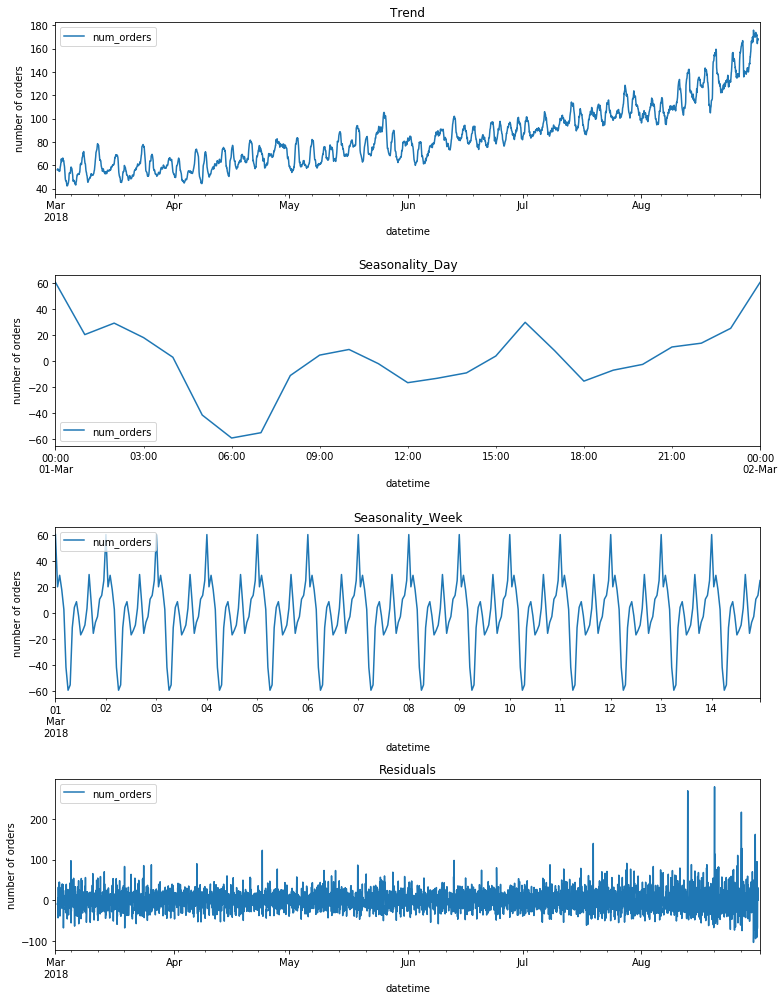

In [61]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(11, 14))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel("number of orders")

plt.subplot(412)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality_Day')
plt.ylabel("number of orders")

plt.subplot(413)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-14 23:59:59'].plot(ax=plt.gca())
plt.title('Seasonality_Week')
plt.ylabel("number of orders")


plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel("number of orders")


plt.tight_layout()

Text(0, 0.5, 'number of orders')

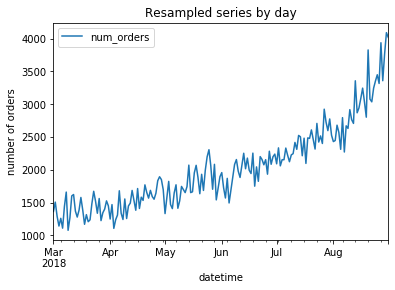

In [63]:
#график ряда после ресемплирования по дням
data.resample('1D').sum().plot()
plt.title('Resampled series by day')
plt.ylabel("number of orders")

Исходя из этих полученных графиков, можно сделать вывод, что присутствует явный тренд на количество заказов. Это зависит от времени месяца и времени дня. После августа явно видно регзкое повышение кол-во числа заказов. В течении дня видно, как кол-во заказов растет в полночь, 10 часов утра, 4 часа дня, немного к 9 вечера и опять к полуночи. Наш график нестанционарный и нужно попробовать решить эту проблему, для обучения модели.

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, верный анализ, это поможет выбрать лаг при построении фич</div>

In [65]:
#попробуем бороться с этим с помощью разности временного ряда
data_shift = data - data.shift()


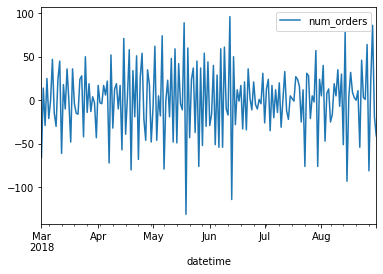

In [68]:
data_shift.resample('1D').sum().plot()

Плюс-минус привели график к стационарному виду.

## Обучение

In [71]:
#создадим признаки для работы модели
#из за того что наблюдается суточная сезонность, то значение max_lag возьмем не более 24
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 6)

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Функция описана верно, молодец! + Спасибо за обоснование, много кто про это забывает
</div>

In [74]:
#удалим строки с образовавшимися нулевыми значениями
data = data.dropna()

data.head()

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,3,2,4,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.333333
2018-03-02 01:00:00,120,1,3,2,4,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.166667
2018-03-02 02:00:00,75,2,3,2,4,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,84.666667
2018-03-02 03:00:00,64,3,3,2,4,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,87.000000
2018-03-02 04:00:00,20,4,3,2,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.666667


In [76]:
#разбитие данных

target = data['num_orders']
features = data.drop('num_orders', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
features, target, shuffle=False,  test_size=0.10, random_state=8888)

In [77]:
#кросс валидация
#для временных рядов нужно использовать разбиение TimeSeriesSplit
def CV_scor_Time(model):
    errors = []
    values = features_train.values

        # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=6) 

        # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = model
        model.fit(values[train], target_train[:len(train)])
        predict = model.predict(values[test])
        RMSE = mean_squared_error(target_train[test],predict)** 0.5
        errors.append(RMSE)

    print('Результаты модели по кросс валидации :', model)
    return np.mean(np.array(errors))
    errors.clear()

#по-хорошему все это нужно было соединить с GridSearchCV и подобрать параметры
# но, подбирал ручками)


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Круто, что вынес общий код для моделей в отдельную функцию. features_train -лучше аргументом указать у функции иначе можно словить неприятные ошибки в будущем
</div>

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
1)Для названий переменных и функций принят snake_case (все буквы строчные)

2) После return когд никогда не исполнится
</div>

In [78]:
%%time
#Wall time: 6.08 s
CV_scor_Time(lgb.LGBMRegressor(num_leaves=31, learning_rate=0.22, n_estimators=500, eval_metric = 'mse'))

Результаты модели по кросс валидации : LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='mse', importance_type='split', learning_rate=0.22,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
CPU times: user 43.6 s, sys: 515 ms, total: 44.1 s
Wall time: 44.5 s


25.952787519040516

In [79]:
%%time
#Wall time: 14.9 s
CV_scor_Time(CatBoostRegressor(max_depth=6, n_estimators=500, random_state=12345, learning_rate=0.23, verbose = False))

Результаты модели по кросс валидации : <catboost.core.CatBoostRegressor object at 0x7f5488ed4210>
CPU times: user 1min 1s, sys: 7.93 s, total: 1min 9s
Wall time: 1min 18s


25.112413614952988

In [80]:
%%time
#Wall time: 54.2 ms
CV_scor_Time(LinearRegression())


Результаты модели по кросс валидации : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CPU times: user 345 ms, sys: 425 ms, total: 770 ms
Wall time: 795 ms


26.835475505499403

## Тестирование

In [81]:
#константная модель, предсказывающая предыдущее значение временного ряда.
pred_const = target_test.shift()
pred_const.iloc[0] = target_train.iloc[-1]
print("Результат константной модели RMSE:", mean_squared_error(target_test,pred_const)** 0.5)


Результат константной модели RMSE: 58.881776776551476


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, круто, что реализовал дамми модель. С ней теперь можно сравнивать результаты обученных моделей</div>

Результат модели  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)  RMSE: 45.83447405433364
Результат модели  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='mse', importance_type='split', learning_rate=0.22,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)  RMSE: 39.417878221389024
Результат модели  <catboost.core.CatBoostRegressor object at 0x7f5488c84e50>  RMSE: 39.703381787042204
CPU times: user 21.4 s, sys: 1.9 s, total: 23.3 s
Wall time: 24.8 s


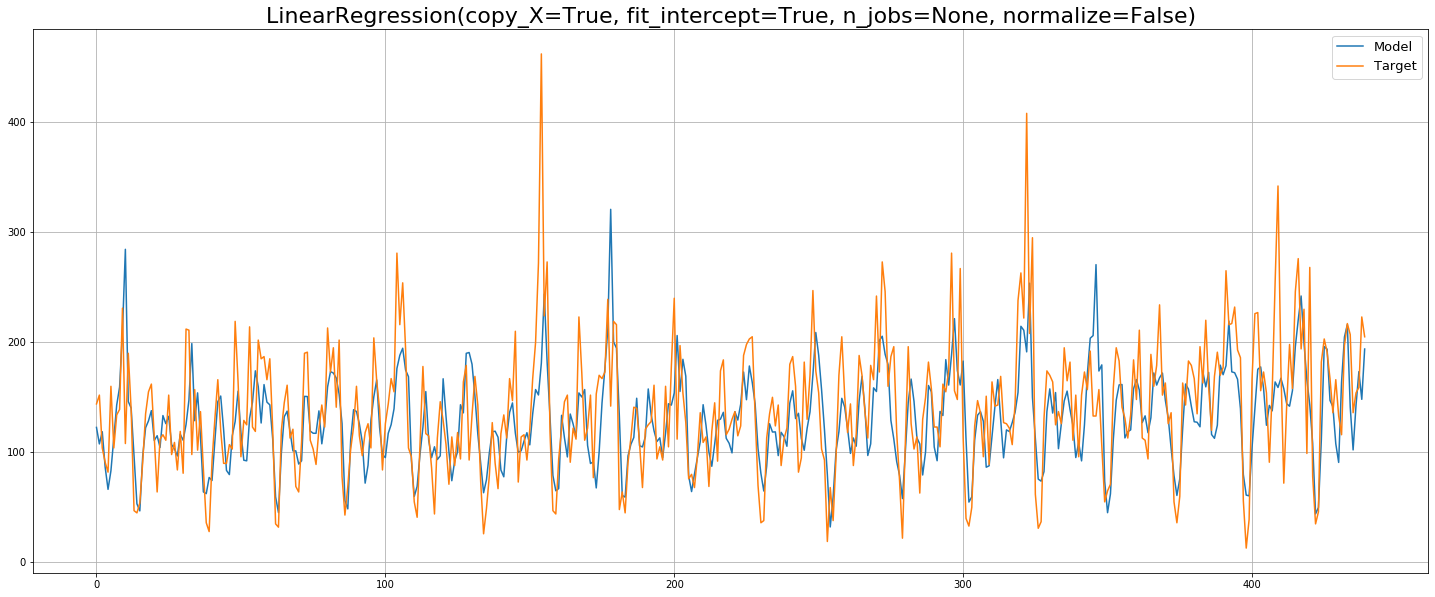

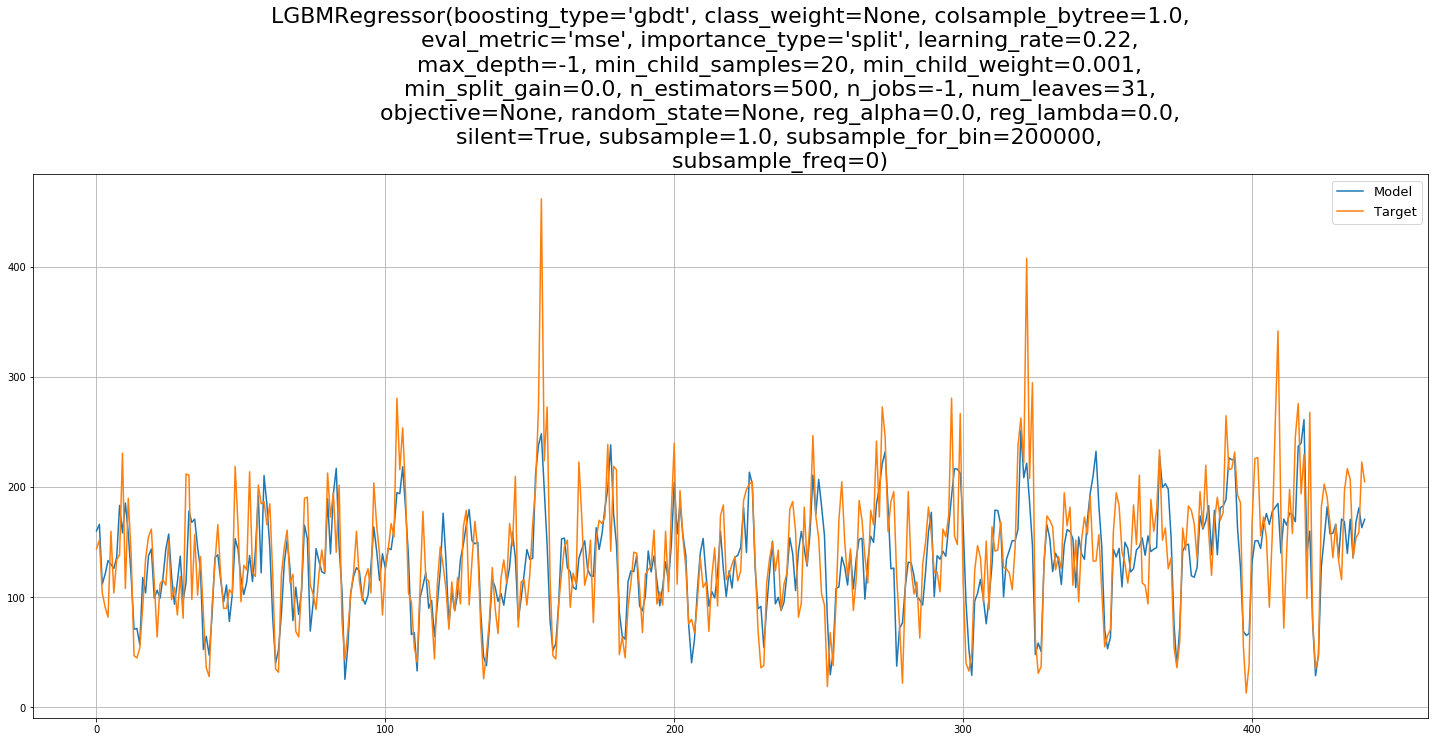

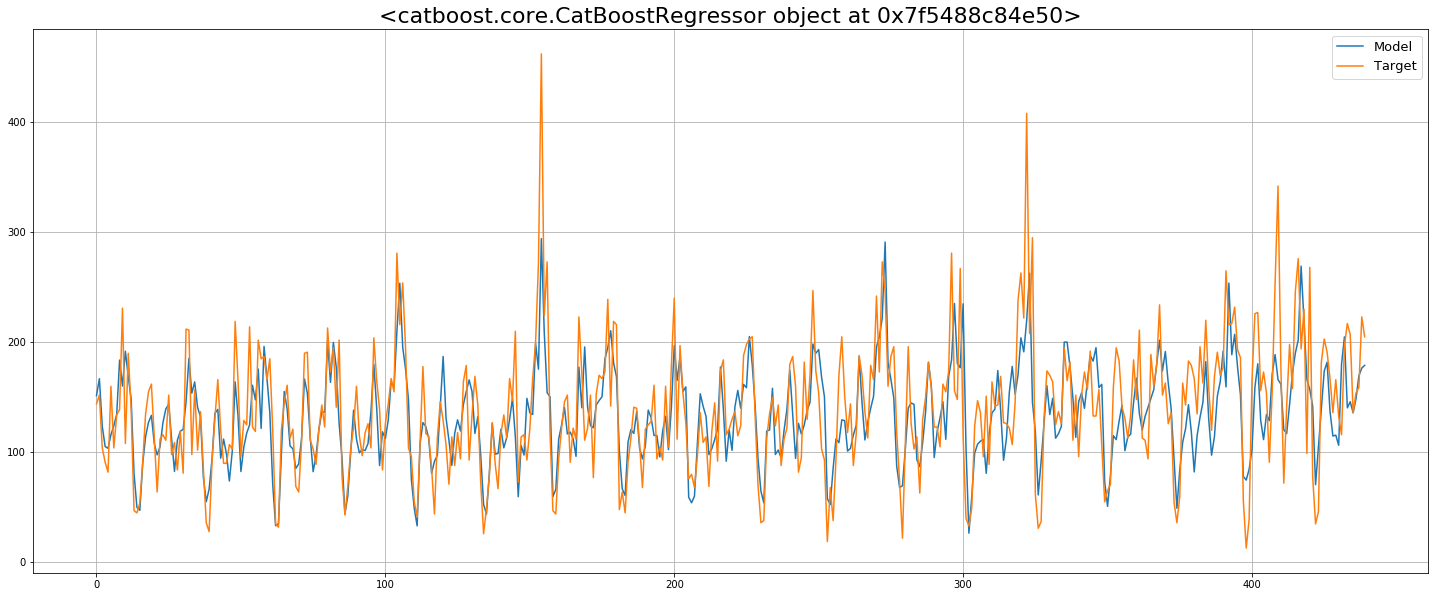

In [82]:
%%time
#Wall time: 4.75 s
#вывод результатов модели на тестовой выборке
def best_model(model):

    model = model
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    print("Результат модели ",model," RMSE:", mean_squared_error(target_test, pred)** 0.5)
    plt.figure(figsize=(25, 10))
    plt.plot(pred, label = "Model")
    plt.plot(target_test.values, label = "Target")
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)
    plt.title(model, fontsize=22)
    
    
best_model(LinearRegression())
best_model(lgb.LGBMRegressor(num_leaves=31,learning_rate=0.22,n_estimators=500,eval_metric = 'mse'))
best_model(CatBoostRegressor(max_depth=6, n_estimators=500, random_state=12345, learning_rate=0.23, verbose = False))

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Бейзлайн успешно пройден, поздравляю!
</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, с такой визуализацией видны слабые места моделей. Молодец!
</div>

Мы можем сделать вывод, что лучшая метрика у модели LGBMRegressor, по графикам видно, что она неплохо справляется со стандартными значениями, но плохо справляется с аномальными выбросами(на графике их 3). 

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Немного не хватает обшего вывода по всему проекту</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Спасибо за качественный проект:
    
- код написан хорошо, радует, что понимаешь, как не дублировать функциональность

- соблюдена структура проекта

- твои модели смогли успешно побить бейзлайн

- удачи в следующих проектах!
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48